# Generate data using Kramers model

The script will first draw a distribution of molecules and equilibrate. Then for each scenario, simulate, and save in individual files.

For Kramers chain, we need to do an additional normalizing step of flow scenarios, because the model itself is normalized by the segmental diffusion (not the longest relaxation time). Renormalization is given by (Doyle et al. 1997):

$$
Wi = 0.0142 N^2 Pe
$$

In addition, we are primarily interested in mechano-chemistry application, where typical Weissenberg numbers are $\mathcal{O}(100)$. Therefore we choose to have $Wi_\max = 1000$ in simulated flows.


In [1]:
import numpy as np
from dilutebrowniandynamics.simulate import simulate_batch
from dilutebrowniandynamics.molecules.adaptive_Kramers_chain import AdaptiveKramersChain
from dilutebrowniandynamics.molecules.Kramers_chain import KramersChain

from scipy.interpolate import interp1d

from ipywidgets import interactive, fixed
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

import json
import datetime
from copy import deepcopy

## Parameters definition

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                       # Number of segments in the Kramers chain
n_ensemble = 100                   # Number of molecules to simulate
n_proc = 16                         # Number of processor cores to use
seq = np.random.SeedSequence(2022)  # Random number seed
polydispersed = True

# Output folder
save_folder = 'outputs/Kramers'
                    
# Name: file
scenarios = {
    'inkjet_0_PD': 'inputs/inkjet/scenario_inkjet_0.npz',
    'inkjet_1_PD': 'inputs/inkjet/scenario_inkjet_1.npz',
    'inkjet_2_PD': 'inputs/inkjet/scenario_inkjet_2.npz',
    'inkjet_3_PD': 'inputs/inkjet/scenario_inkjet_3.npz',
    'inkjet_4_PD': 'inputs/inkjet/scenario_inkjet_4.npz',
#    'contraction_0_PD': 'inputs/contraction/scenario_contraction_0.npz',
#    'contraction_1_PD': 'inputs/contraction/scenario_contraction_1.npz',
#    'contraction_2_PD': 'inputs/contraction/scenario_contraction_2.npz',
#    'contraction_3_PD': 'inputs/contraction/scenario_contraction_3.npz',
#    'contraction_4_PD': 'inputs/contraction/scenario_contraction_4.npz',
#    'contraction_5_PD': 'inputs/contraction/scenario_contraction_5.npz',
#    'contraction_6_PD': 'inputs/contraction/scenario_contraction_6.npz',
#    'elongation_0_noBF': 'inputs/elongation/scenario_elongation_0.npz',
#    'random_0': 'inputs/random/scenario_random_0.npz',
#    'random_1': 'inputs/random/scenario_random_1.npz',
#    'random_2': 'inputs/random/scenario_random_2.npz',
#    'random_3': 'inputs/random/scenario_random_3.npz',
#    'random_4': 'inputs/random/scenario_random_4.npz',
#    'sonication_0_PD': 'inputs/sonication/scenario_sonication_0.npz',
#    'sonication_1_PD': 'inputs/sonication/scenario_sonication_1.npz',
#    'sonication_2_PD': 'inputs/sonication/scenario_sonication_2.npz',
#    'sonication_3_PD': 'inputs/sonication/scenario_sonication_3.npz',
#    'sonication_4_PD': 'inputs/sonication/scenario_sonication_4.npz',
    'turbulence_0_PD': 'inputs/turbulence/scenario_turbulence_0.npz',
    'turbulence_1_PD': 'inputs/turbulence/scenario_turbulence_1.npz',
    'turbulence_2_PD': 'inputs/turbulence/scenario_turbulence_2.npz',
    'turbulence_3_PD': 'inputs/turbulence/scenario_turbulence_3.npz',
    'turbulence_4_PD': 'inputs/turbulence/scenario_turbulence_4.npz',
}

## Initialise molecules
We call the `from_normal_distribution` constructor. Note that we pass a random seed (`SeedSequence` object) to ensure thread-safe random number generation and reproducible results.

1.0098025630066207


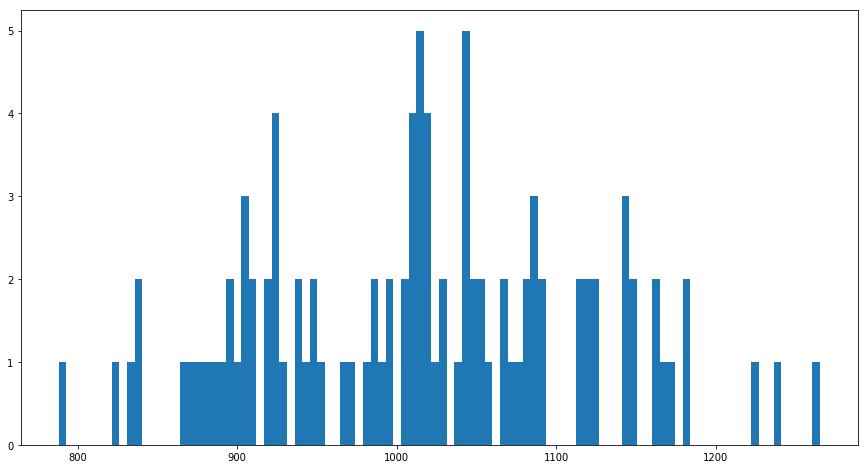

In [3]:

seeds = seq.spawn(n_ensemble)

if polydispersed:

    # Dispersity
    Ns = np.random.lognormal(mean=np.log(n_links), sigma=0.11, size=n_ensemble)  # 0.215
    Ns = Ns.astype(int)

    PDI = np.average(Ns**2)/np.average(Ns)**2
    print(PDI)

    plt.hist(Ns, 100)
    
    molecules = [KramersChain.from_normal_distribution(N, seed) for N, seed in zip(Ns, seeds)]

else:
    # Starting vectors
    molecules = [AdaptiveKramersChain.from_normal_distribution(n_links, seed)
                 for seed in seeds]

## Initial relaxation
Molecular dynamics simulations are usually preceeded by a relaxation/thermalisation step, which in our case is just a simulation with no velocity gradient.

In [4]:
gradU = np.zeros((3, 3))
dt = .01                                    # Time step value (dimensionless)
n_steps = 1000       # Equilibriate at bead scale.
print(f"Number of time steps: {n_steps}")
write_interval = 100   # Record frequency (in number of time steps)
observables, molecules_init = simulate_batch(molecules, gradU, dt, n_steps, 
                                             write_interval=write_interval, 
                                             no_average=('g_max', 'i_max', 'g_13', 'g_12', 'g_23'),
                                             n_proc=n_proc)

Number of time steps: 1000
Physical time to compute: 10.0
Calculation started on 16 cores.


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


We can investigate the dumbbell distribution in a number of ways. Let's look at time series and histograms.

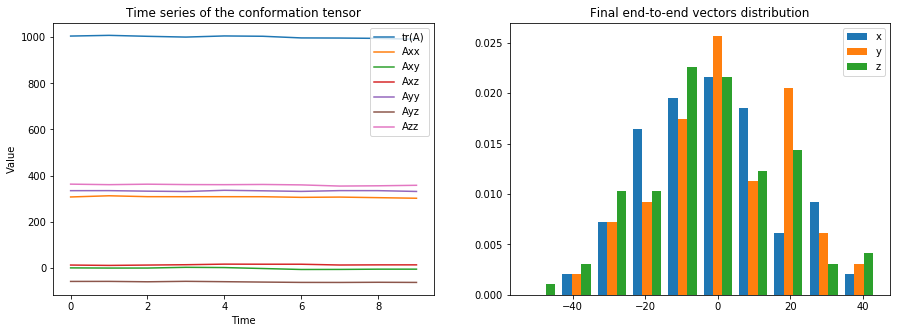

In [5]:
t = np.arange(n_steps//write_interval)*dt*write_interval
A = observables['A_average']
trA = np.trace(A, axis1=1, axis2=2)
REEs = np.array([molecule.REE for molecule in molecules])

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(t, trA, label='tr(A)')
ax[0].plot(t, A[:,0,0], label='Axx')
ax[0].plot(t, A[:,0,1], label='Axy')
ax[0].plot(t, A[:,0,2], label='Axz')
ax[0].plot(t, A[:,1,1], label='Ayy')
ax[0].plot(t, A[:,1,2], label='Ayz')
ax[0].plot(t, A[:,2,2], label='Azz')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].set_title('Time series of the conformation tensor')
bins = int(np.sqrt(n_ensemble))
ax[1].hist([REEs[:,0], REEs[:,1], REEs[:,2]], bins=bins, density=True, label=['x','y','z'])
ax[1].legend()
ax[1].set_title('Final end-to-end vectors distribution')
plt.show()

## Simulations

Now let's simulate each scenario. We will use the interpolator `scipy.interpolate.interp1d` with the property `kind=previous` for the sudden elongation and random tensor, `kind=linear` for realistic flows.

In [ ]:
dt = 0.01
write_interval = 100


for name, file in scenarios.items():
    
    # Rescale factor
    # --------------
    f = Wi_max/(0.0142*n_links**2)

    # Build scenario
    # --------------
    scenario = np.load(file)
    t_base = scenario['t']
    t_base = t_base/f
    gradU_base = scenario['gradU']*f
    if name.startswith('elongation') or name.startswith('random'):
        kind='previous'
    else:
        kind='linear'
    gradU = interp1d(t_base, gradU_base, axis=0, kind=kind, bounds_error=False, 
                     fill_value=(gradU_base[0], gradU_base[-1]), assume_sorted=True)
    
    # Simulate
    # --------
    print(f"Simulate {name}")
    print(f"---------{'-'*len(name)}")
    
    n_steps = int(t_base[-1]/dt)
    #write_interval = max(1, 10**(int(np.log10(n_steps))-3))
    
    print(f"Number of time steps: {n_steps}")
    print(f"Number of recorded steps: {n_steps//write_interval}")
    pre = datetime.datetime.now()
    
    molecules = deepcopy(molecules_init)
    observables, _ = simulate_batch(molecules, gradU, dt, n_steps, write_interval=write_interval,
                                    no_average=('g_max', 'i_max', 'g_13', 'g_12', 'g_23'),
                                    n_proc=n_proc)
    
    observables['t'] = np.arange(n_steps//write_interval)*dt*write_interval
    observables['gradU'] = gradU(observables['t'])
    
    
    # Save
    # ----

    params = {'model': molecules[0].__class__.__name__,
              'n_links': n_links,
              'n_ensemble': n_ensemble,
              'dt': dt,
              'write_interval': write_interval,
              'n_proc': n_proc,
              'compute date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
              'compute cost': str(datetime.datetime.now() - pre)
              }

    np.savez_compressed(f"{save_folder}/{name}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}", **observables)
    json.dump(params, open( f"{save_folder}/{name}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.json", 'w' ) )

Simulate inkjet_0_PD
--------------------
Number of time steps: 30532
Number of recorded steps: 305
Physical time to compute: 305.32
Calculation started on 16 cores.


100%|██████████| 100/100 [18:43<00:00, 11.23s/it] 

Simulate inkjet_1_PD
--------------------
Number of time steps: 40996
Number of recorded steps: 409
Physical time to compute: 409.96000000000004


Calculation started on 16 cores.


100%|██████████| 100/100 [20:05<00:00, 12.05s/it] 


Simulate inkjet_2_PD
--------------------
Number of time steps: 33110
Number of recorded steps: 331
Physical time to compute: 331.1
Calculation started on 16 cores.


100%|██████████| 100/100 [15:59<00:00,  9.59s/it] 


Simulate inkjet_3_PD
--------------------
Number of time steps: 32630
Number of recorded steps: 326
Physical time to compute: 326.3
Calculation started on 16 cores.


100%|██████████| 100/100 [21:43<00:00, 13.03s/it] 

Simulate inkjet_4_PD
--------------------
Number of time steps: 39176
Number of recorded steps: 391
Physical time to compute: 391.76


Calculation started on 16 cores.


100%|██████████| 100/100 [20:01<00:00, 12.01s/it] 


Simulate turbulence_0_PD
------------------------
Number of time steps: 69685
Number of recorded steps: 696
Physical time to compute: 696.85
Calculation started on 16 cores.


100%|██████████| 100/100 [5:31:21<00:00, 198.82s/it] 


Simulate turbulence_1_PD
------------------------
Number of time steps: 69685
Number of recorded steps: 696
Physical time to compute: 696.85
Calculation started on 16 cores.


100%|██████████| 100/100 [13:44:02<00:00, 494.42s/it]  


Simulate turbulence_2_PD
------------------------
Number of time steps: 69685
Number of recorded steps: 696
Physical time to compute: 696.85
Calculation started on 16 cores.


100%|██████████| 100/100 [43:47:00<00:00, 1576.21s/it]  


Simulate turbulence_3_PD
------------------------
Number of time steps: 69685
Number of recorded steps: 696
Physical time to compute: 696.85
Calculation started on 16 cores.


 22%|██▏       | 22/100 [9:14:53<41:58:35, 1937.37s/it] 

## Inspect